In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from copy import deepcopy # To copy objects

# --- Imports for Portfolio Optimization (Part 2) ---
import itertools # To create combinations
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting 

import riskfolio as rf
import ta
import scipy
print(scipy.__version__)

from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# --- Global Settings ---
sns.set_theme(style="darkgrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

1.16.1


## PART I: PREPROCESSING


### 1. Gather data

In [2]:
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'SPY']
tickers = ['TSLA', 'META', 'NVDA', 'JPM', 'JNJ' ]
n = len(tickers)
risk_free_rate = 0.02
cash = 10000000  # 10 million USD

start_date = "2023-01-01"
end_date = "2025-10-31"
split_date = "2024-12-31" 
split_validation_date = "2025-05-31"

# def get_data( tickers, start_date, end_date):
#     try:
#         print(f"Getting data for {n} tickers: {tickers}")
#         print(f"Total period: {start_date} to {end_date}")
#         data = yf.download(tickers, start=start_date, end=end_date)['Close']
#         if data.empty:
#             raise ValueError("No data fetched.")
        
#         print("Data loading completed.")
#         return data
#     except Exception as e:
#         print(f"ERROR: {e}")
#         return None

# all_data = get_data(tickers, start_date, end_date)

In [3]:
all_data = pd.read_csv('stock_data1.csv', index_col=0, parse_dates=True)
# all_data.to_csv('stock_data1.csv'  )
all_data

,JNJ,JPM,META,NVDA,TSLA
Date,,,,,
2023-01-03,162.655899,125.492218,123.975723,14.301477,108.099998
2023-01-04,164.426788,126.662453,126.589607,14.735069,113.639999
2023-01-05,163.212708,126.634392,126.162247,14.251529,110.339996
2023-01-06,164.536285,129.057632,129.223389,14.844965,113.059998
2023-01-09,160.273407,128.524277,128.676727,15.613241,119.769997
...,...,...,...,...,...
2025-10-24,189.198730,300.440002,738.359985,186.259995,433.720001
2025-10-27,189.099365,304.149994,750.820007,191.490005,452.420013
2025-10-28,185.750626,305.359985,751.440002,201.029999,460.549988


In [4]:
all_data.index = all_data.index.tz_localize('America/New_York', ambiguous='infer')
print(f"Timezone after localization: {all_data.index.tz}")

train_data = all_data.loc[:split_date]
validation_data = all_data.loc[split_date:split_validation_date]
test_data = all_data.loc[split_validation_date:]

print(f"Train Set: {train_data.index.min().date()} -> {train_data.index.max().date()} ({len(train_data)} days)")
print(f"Validation Set:  {validation_data.index.min().date()} -> {validation_data.index.max().date()} ({len(validation_data)} days)")
print(f"Test Set:  {test_data.index.min().date()} -> {test_data.index.max().date()} ({len(test_data)} days)")

Timezone after localization: America/New_York
Train Set: 2023-01-03 -> 2024-12-31 (502 days)
Validation Set:  2024-12-31 -> 2025-05-30 (103 days)
Test Set:  2025-06-02 -> 2025-10-30 (106 days)


### 2. Return and risk calculation

In [5]:
return_train = expected_returns.mean_historical_return(train_data, frequency=252)
cov_train = risk_models.sample_cov(train_data, frequency=252)

In [ ]:
# Use SPY as an example
# spy = all_data[['SPY']].copy().dropna()

# # 1. Calculate Simple Return
# spy['Returns_Simple'] = spy['SPY'].pct_change()

# # 2. Calculate Log Return
# spy['Returns_Log'] = np.log(spy['SPY'] / spy['SPY'].shift(1))

# # Drop the first NA row (from .pct_change() and .shift())
# spy = spy.dropna()

# print(spy.head())

# # Price chart and histogram of SPY log returns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# # Price plot
# spy['SPY'].plot(ax=ax1, title='SPY Price', color='#156ffb')
# ax1.set_ylabel('Price (USD)')
# ax1.grid(True)

# # Histogram of log returns
# sns.histplot(spy['Returns_Log'].dropna(), bins=100, kde=True, ax=ax2, color='#8fce00')
# ax2.set_title('Distribution of SPY Daily Log Returns')
# ax2.set_xlabel('Log Return')
# ax2.set_ylabel('Frequency')
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

KeyError: "None of [Index(['SPY'], dtype='object')] are in the [columns]"

### 3. Rolling statistic

SMA

Visualizing SPY 50 and 200 SMA (Last 2 years):


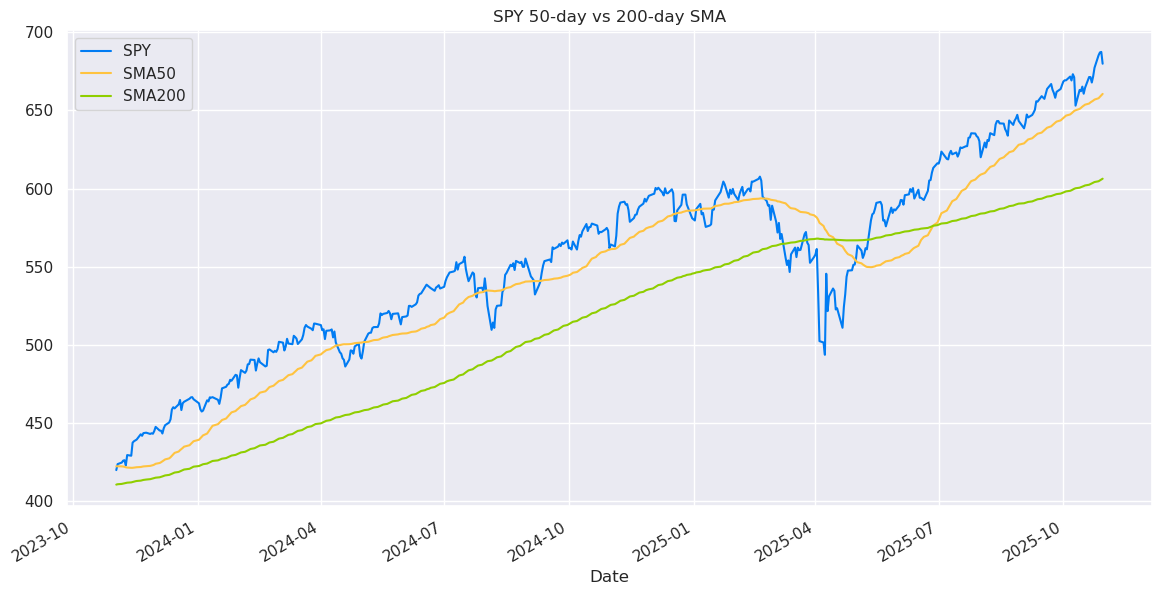

In [ ]:
# Calculate 50-day and 200-day SMA for SPY
# spy['SMA50'] = spy['SPY'].rolling(window=50).mean()
# spy['SMA200'] = spy['SPY'].rolling(window=200).mean()

# # Visualize SMA (only last 2 years for clarity)
# print("Visualizing SPY 50 and 200 SMA (Last 2 years):")
# spy.iloc[-500:][['SPY', 'SMA50', 'SMA200']].plot(
#     title='SPY 50-day vs 200-day SMA', 
#     figsize=(14, 7), 
#     color={'SPY': '#017cf3', 'SMA50': '#ffc340', 'SMA200': '#8fce00'}
# )
# plt.show()

Volatility

Visualizing SPY 21-day Rolling Volatility (Annualized):


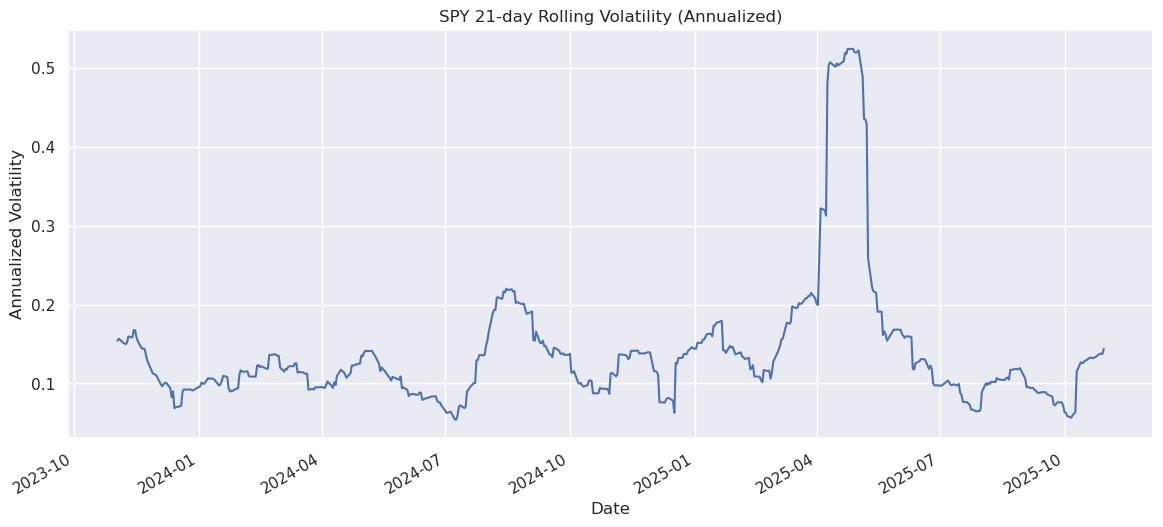

In [ ]:
# Calculate 21-day rolling std dev of Log Returns
# (21 trading days ~ 1 month)
# Multiply by sqrt(252) (trading days in a year) to *annualize* it
# spy['Volatility'] = spy['Returns_Log'].rolling(window=21).std() * np.sqrt(252)

# print("Visualizing SPY 21-day Rolling Volatility (Annualized):")
# spy['Volatility'].iloc[-500:].plot(title='SPY 21-day Rolling Volatility (Annualized)', figsize=(14, 6))
# plt.ylabel('Annualized Volatility')
# plt.show()

Rolling Correlation

Visualizing 60-day Rolling Correlation (AAPL vs SPY):


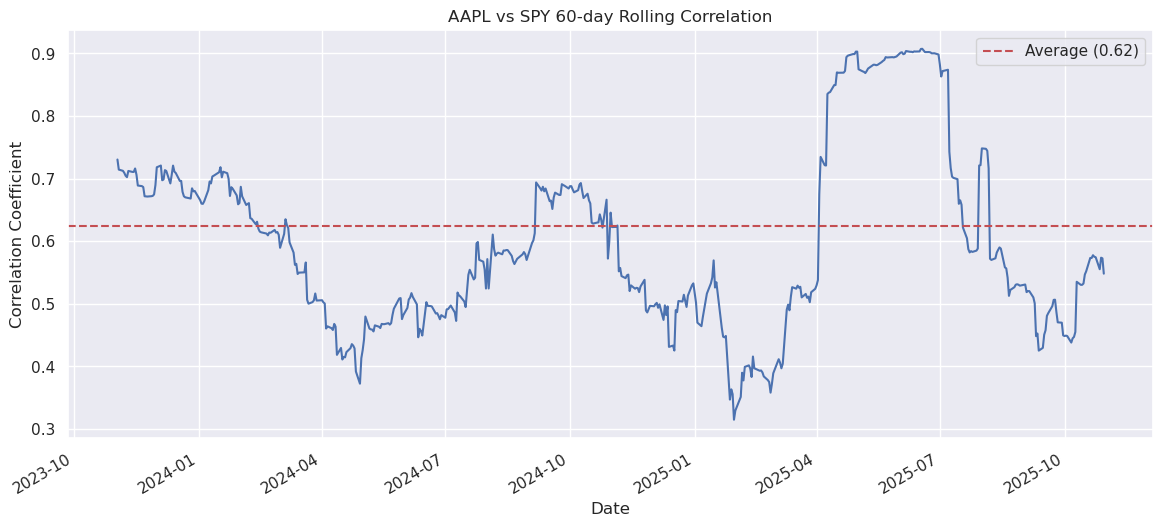

In [ ]:
# Get log returns for AAPL and SPY (the market)
# market_returns = np.log(all_data['SPY'] / all_data['SPY'].shift(1))
# stock_returns = np.log(all_data['AAPL'] / all_data['AAPL'].shift(1))

# # Calculate 60-day rolling correlation (~ 3 months)
# rolling_corr = stock_returns.rolling(window=60).corr(market_returns)
# rolling_corr = rolling_corr.dropna()

# print("Visualizing 60-day Rolling Correlation (AAPL vs SPY):")
# rolling_corr.iloc[-500:].plot(title='AAPL vs SPY 60-day Rolling Correlation', figsize=(14, 6))
# plt.ylabel('Correlation Coefficient')
# plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label=f'Average ({rolling_corr.mean():.2f})')
# plt.legend()
# plt.show()

- MFI _ Money flow index
- RSI
- MACD
- SMA
- ADX
- ROC

## PART II: COMPREHENSIVE PORTFOLIO OPTIMIZZATION STRATEGY - SUMMARY

### Strategy Components Summary:

**1. Portfolio Optimization:**
- Dynamic rebalancing with rolling windows
- Risk-adjusted weight allocation
- Technical signal integration
- Position size constraints (5%-40% per asset)
- Diversification

- Choose the most optimal stock out of the portfolio

**2. Technical Analysis & Buy/Sell Signals:**
- Multi-indicator approach (RSI, MACD, Bollinger Bands, Moving Averages, Momentum)
- Signal aggregation and scoring (-1 to +1 scale)
- Adaptive position sizing based on signal strength

**3. Risk Management Framework:**
- Volatility targeting (12% annual target)
- Maximum drawdown control (15% limit)
- Stop-loss implementation (5% per position)
- Value-at-Risk monitoring
- Transaction cost consideration

### 2: PORTFOLIO OPTIMIZATION METHODS


#### 2.1 Dynamic rebalancing with rolling windows

In [7]:
# Dynamic Portfolio Optimization with Rolling Windows


def dynamic_portfolio_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic portfolio optimization with rolling windows
    
    Parameters:
    - data: Price data DataFrame
    - lookback_window: Days to look back for optimization (63 = ~3 months)
    - rebalance_freq: Rebalancing frequency in days (21 = ~1 month)
    """
    
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize portfolio weights history
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data for optimization
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize portfolio (Max Sharpe with constraints)
            try:
                current_weights = optimize_max_sharpe_constrained(mu, cov, risk_free_rate)
            except:
                # Fallback to equal weights if optimization fails
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()


def optimize_max_sharpe_constrained(mu, cov, rf_rate=0.02, max_weight=0.4, min_weight=0.05):
    """
    Optimize portfolio for maximum Sharpe ratio with weight constraints
    """
    n_assets = len(mu)
    
    def objective(weights):
        portfolio_return = np.dot(weights, mu)
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        return -(portfolio_return - rf_rate) / portfolio_vol  # Negative for minimization
    
    # Constraints
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
    bounds = [(min_weight, max_weight) for _ in range(n_assets)]
    
    # Initial guess
    x0 = np.array([1/n_assets] * n_assets)
    
    # Optimize
    result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        return np.array([1/n_assets] * n_assets)

print("Dynamic Portfolio Optimization functions defined successfully.")

# Apply dynamic optimization to our data
print("\n--- Applying Dynamic Portfolio Optimization ---")
dynamic_weights, dynamic_returns = dynamic_portfolio_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Dynamic optimization completed for {len(dynamic_returns)} trading days")
print("\nSample of dynamic weights (last 10 days):")
print(dynamic_weights.tail(10).round(3))

Dynamic Portfolio Optimization functions defined successfully.

--- Applying Dynamic Portfolio Optimization ---
Dynamic optimization completed for 438 trading days

Sample of dynamic weights (last 10 days):
                            JNJ       JPM      META      NVDA     TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-18 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-19 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-20 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-23 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-24 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-26 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-27 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-30 00:00:00-05:00  0.05  0.148267  0.368271  0.293722  0.13974
2024-12-31 0

#### 2.2 Kelly Criterion Dynamic Portfolio Optimization

In [8]:
# Kelly Criterion Portfolio Optimization

def kelly_criterion_optimization(mu, cov, confidence_level=0.6):
    """
    Kelly Criterion portfolio optimization
    
    Formula: f = (bp - q) / b
    Where:
    - f = fraction of capital to bet
    - b = odds received (return/risk ratio)
    - p = probability of winning
    - q = probability of losing (1-p)
    """
    n_assets = len(mu)
    kelly_weights = np.zeros(n_assets)
    
    # Calculate individual asset Kelly fractions
    volatilities = np.sqrt(np.diag(cov))
    
    for i in range(n_assets):
        if volatilities[i] > 0 and mu[i] > 0:
            # Estimate win probability based on Sharpe ratio
            sharpe = mu[i] / volatilities[i]
            win_prob = min(0.5 + sharpe * 0.1, 0.85)  # Cap at 85%
            
            # Kelly fraction calculation
            odds_ratio = mu[i] / volatilities[i]  # Return to risk ratio
            kelly_fraction = (odds_ratio * win_prob - (1 - win_prob)) / odds_ratio
            
            # Apply conservative scaling (fractional Kelly)
            kelly_weights[i] = max(0, kelly_fraction * 0.25)  # Use 25% of full Kelly
    
    # Normalize weights to sum to 1
    if kelly_weights.sum() > 0:
        kelly_weights = kelly_weights / kelly_weights.sum()
    else:
        kelly_weights = np.array([1/n_assets] * n_assets)  # Equal weights fallback
    
    return kelly_weights

def dynamic_kelly_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Kelly Criterion optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate expected returns and covariance
            mu = hist_returns.mean() * 252
            cov = hist_returns.cov() * 252
            
            # Optimize using Kelly Criterion
            try:
                current_weights = kelly_criterion_optimization(mu, cov)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Kelly Criterion optimization functions defined successfully.")

# Apply Kelly optimization to our data
print("\n--- Applying Kelly Criterion Dynamic Portfolio Optimization ---")
kelly_weights, kelly_returns = dynamic_kelly_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Kelly optimization completed for {len(kelly_returns)} trading days")
print("\nSample of Kelly weights (last 10 days):")
print(kelly_weights.tail(10).round(3))

Kelly Criterion optimization functions defined successfully.

--- Applying Kelly Criterion Dynamic Portfolio Optimization ---
Kelly optimization completed for 438 trading days

Sample of Kelly weights (last 10 days):
                           JNJ       JPM      META      NVDA      TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-18 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-19 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-20 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-23 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-24 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-26 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-27 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
2024-12-30 00:00:00-05:00  0.0  0.172959  0.271824  0.291673  0.263543
20

#### 2.3 Risk Parity Dynamic Portfolio Optimization

In [9]:
# Risk Parity Portfolio Optimization

def risk_parity_optimization(cov, max_iterations=1000, tolerance=1e-8):
    """
    Risk Parity portfolio optimization using iterative algorithm
    
    Objective: Each asset contributes equally to portfolio risk
    """
    n_assets = len(cov)
    
    # Start with equal weights
    weights = np.array([1/n_assets] * n_assets)
    
    # Iterative algorithm to find risk parity weights
    for iteration in range(max_iterations):
        # Calculate risk contributions
        portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        marginal_risk = np.dot(cov, weights) / portfolio_vol
        risk_contributions = weights * marginal_risk
        
        # Target risk contribution (equal for all assets)
        target_risk = portfolio_vol ** 2 / n_assets
        
        # Update weights based on risk contribution differences
        risk_diff = risk_contributions - target_risk
        
        # Convergence check
        if np.max(np.abs(risk_diff)) < tolerance:
            break
        
        # Update weights (move away from over-contributing assets)
        adjustment_factor = 0.05  # Learning rate
        weight_updates = -adjustment_factor * risk_diff / marginal_risk
        weights = weights + weight_updates
        
        # Ensure non-negative weights and renormalize
        weights = np.maximum(weights, 1e-8)
        weights = weights / weights.sum()
    
    return weights

def dynamic_risk_parity_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Dynamic Risk Parity optimization with rolling windows
    """
    returns = data.pct_change().dropna()
    n_assets = len(data.columns)
    
    # Initialize tracking
    weights_history = pd.DataFrame(index=returns.index, columns=data.columns)
    portfolio_returns = pd.Series(index=returns.index, dtype=float)
    
    # Initial equal weights
    current_weights = np.array([1/n_assets] * n_assets)
    
    for i in range(lookback_window, len(returns)):
        current_date = returns.index[i]
        
        # Rebalance check
        if i % rebalance_freq == 0 or i == lookback_window:
            # Get historical data
            hist_returns = returns.iloc[i-lookback_window:i]
            
            # Calculate covariance matrix
            cov = hist_returns.cov() * 252
            
            # Optimize using Risk Parity
            try:
                # Check if covariance matrix is valid
                eigenvals = np.linalg.eigvals(cov)
                if np.all(eigenvals > 0):
                    current_weights = risk_parity_optimization(cov)
                else:
                    # Fallback: use correlation matrix with equal volatilities
                    corr = hist_returns.corr()
                    vol_avg = hist_returns.std().mean() * np.sqrt(252)
                    cov_regularized = corr * (vol_avg ** 2)
                    current_weights = risk_parity_optimization(cov_regularized)
            except:
                current_weights = np.array([1/n_assets] * n_assets)
        
        # Record weights and calculate portfolio return
        weights_history.iloc[i] = current_weights
        portfolio_returns.iloc[i] = np.dot(current_weights, returns.iloc[i])
    
    return weights_history.dropna(), portfolio_returns.dropna()

print("Risk Parity optimization functions defined successfully.")

# Apply Risk Parity optimization to our data
print("\n--- Applying Risk Parity Dynamic Portfolio Optimization ---")
rp_weights, rp_returns = dynamic_risk_parity_optimization(train_data, lookback_window=63, rebalance_freq=21)

print(f"Risk Parity optimization completed for {len(rp_returns)} trading days")
print("\nSample of Risk Parity weights (last 10 days):")
print(rp_weights.tail(10).round(3))

Risk Parity optimization functions defined successfully.

--- Applying Risk Parity Dynamic Portfolio Optimization ---
Risk Parity optimization completed for 438 trading days

Sample of Risk Parity weights (last 10 days):
                           JNJ       JPM      META      NVDA      TSLA
Date                                                                  
2024-12-17 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-18 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-19 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-20 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-23 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-24 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-26 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-27 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.117894
2024-12-30 00:00:00-05:00  0.0  0.308698  0.362655  0.210753  0.11789

#### 2.4 Optimize $k$-of-$n$ assets (Max Sharpe)

In [10]:
print(f"--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---")
train_returns = train_data.pct_change().dropna()

# 1. Global tracking variables
global_best_sharpe_k = -np.inf
global_best_weights_k_sharpe = None
all_results_sharpe = [] 

# 2. Calculate base metrics (from mu_train, S_train already calculated in 2.2)
individual_vol_series_train = pd.Series(np.sqrt(np.diag(cov_train)), index=tickers)
individual_sharpes_train = (return_train - risk_free_rate) / individual_vol_series_train
individual_vol_train = individual_vol_series_train.to_dict()

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            # 5. Optimize for this combination
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.max_sharpe(risk_free_rate=risk_free_rate)
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results
            if sharpe > global_best_sharpe_k:
                global_best_sharpe_k = sharpe
                global_best_weights_k_sharpe = weights_dict
            
            all_results_sharpe.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================")
print(f"Highest Global Sharpe: {global_best_sharpe_k:.4f} (with k={len(global_best_weights_k_sharpe)}) ")
print("Static Weights found (k-MaxSharpe):")
print(pd.Series(global_best_weights_k_sharpe))

# 8. Print all results dataframe
all_results_sharpe_df = pd.DataFrame(all_results_sharpe).sort_values(by='Sharpe', ascending=False).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Sharpe) ---")
print(all_results_sharpe_df[['k', 'Combination', 'Sharpe', 'Volatility']].head(15))

--- STARTING k-of-n SEARCH (Max Sharpe) on Train Set ---

================ OPTIMAL RESULT (k-Max Sharpe) - TRAINING ================
Highest Global Sharpe: 5.8135 (with k=1) 
Static Weights found (k-MaxSharpe):
TSLA    1.0
dtype: float64

--- Top 15 Combinations (Ranked by Sharpe) ---
    k                             Combination    Sharpe  Volatility
0   1                               ('TSLA',)  5.813462    0.158333
1   1                               ('NVDA',)  5.406641    0.381860
2   1                               ('META',)  5.236791    0.221655
3   5  ('TSLA', 'META', 'NVDA', 'JPM', 'JNJ')  4.452744    0.299017
4   4          ('META', 'NVDA', 'JPM', 'JNJ')  4.452744    0.299017
5   4         ('TSLA', 'META', 'NVDA', 'JPM')  4.452593    0.303486
6   3                 ('META', 'NVDA', 'JPM')  4.452593    0.303486
7   4         ('TSLA', 'META', 'NVDA', 'JNJ')  4.379997    0.338436
8   3                 ('META', 'NVDA', 'JNJ')  4.378018    0.341102
9   3                ('TSLA', 'MET

#### 2.5 Optimize $k$-of-$n$ assets (Min Volatility)

In [11]:
print(f"--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---")

# 1. Global tracking variables
global_best_vol_k = np.inf
global_best_weights_k_vol = None
all_results_vol = [] 

# (No need to recalculate individual_vol_train, use from 2.6)

# 3. Outer loop: Iterate k from 1 to n
for k in range(1, n + 1):
    # 4. Inner loop: Iterate combinations C(n, k)
    for combo in itertools.combinations(tickers, k):
        combo_list = list(combo)
        combo_str = str(combo)
        ret, vol, sharpe, weights_dict = (np.nan, np.nan, np.nan, {})

        try:
            if k == 1:
                ticker = combo_list[0]
                ret = return_train[ticker]
                vol = individual_vol_train[ticker]
                sharpe = individual_sharpes_train[ticker]
                weights_dict = {ticker: 1.0}
            else:
                mu_combo = return_train[combo_list]
                S_combo = cov_train.loc[combo_list, combo_list]
                ef_combo = EfficientFrontier(mu_combo, S_combo, weight_bounds=(0, 1))
                weights = ef_combo.min_volatility() # <-- CHANGE OBJECTIVE
                ret, vol, sharpe = ef_combo.portfolio_performance(risk_free_rate=risk_free_rate)
                weights_dict = ef_combo.clean_weights()

            # 6. Track results (CHANGE OBJECTIVE)
            if vol < global_best_vol_k:
                global_best_vol_k = vol
                global_best_weights_k_vol = weights_dict
            
            all_results_vol.append({'k': k, 'Combination': combo_str, 'Sharpe': sharpe, 'Volatility': vol, 'Return (APY)': ret, 'Weights': weights_dict})
        except Exception as e:
            pass 

# 7. Print final results
print("\n================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================")
print(f"Lowest Global Volatility: {global_best_vol_k:.4f} (with k={len(global_best_weights_k_vol)}) ")
print("Static Weights found (k-MinVol):")
print(pd.Series(global_best_weights_k_vol))

# 8. Print all results dataframe
all_results_vol_df = pd.DataFrame(all_results_vol).sort_values(by='Volatility', ascending=True).reset_index(drop=True)
print("\n--- Top 15 Combinations (Ranked by Volatility) ---")
print(all_results_vol_df[['k', 'Combination', 'Volatility', 'Sharpe']].head())

--- STARTING k-of-n SEARCH (Min Volatility) on Train Set ---

================ OPTIMAL RESULT (k-Min Vol) - TRAINING ================
Lowest Global Volatility: 0.1281 (with k=5) 
Static Weights found (k-MinVol):
TSLA    0.00778
META    0.06795
NVDA    0.07336
JPM     0.19173
JNJ     0.65918
dtype: float64

--- Top 15 Combinations (Ranked by Volatility) ---
   k                             Combination  Volatility    Sharpe
0  5  ('TSLA', 'META', 'NVDA', 'JPM', 'JNJ')    0.128132  1.906395
1  4          ('META', 'NVDA', 'JPM', 'JNJ')    0.128200  1.909063
2  4          ('TSLA', 'NVDA', 'JPM', 'JNJ')    0.130340  1.665959
3  3                  ('NVDA', 'JPM', 'JNJ')    0.130583  1.658982
4  4          ('TSLA', 'META', 'JPM', 'JNJ')    0.132365  1.218513


#### 2.6 Strategy Comparison on Train test

=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===
=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 438

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2024-12-17 00:00:00-05:00             -0.0012         0.0031              -0.0026
2024-12-18 00:00:00-05:00             -0.0337        -0.0407              -0.0355
2024-12-19 00:00:00-05:00              0.0030         0.0028               0.0043
2024-12-20 00:00:00-05:00              0.0011        -0.0014               0.0023
2024-12-23 00:00:00-05:00              0.0240         0.0241               0.0205
2024-12-24 00:00:00-05:00          

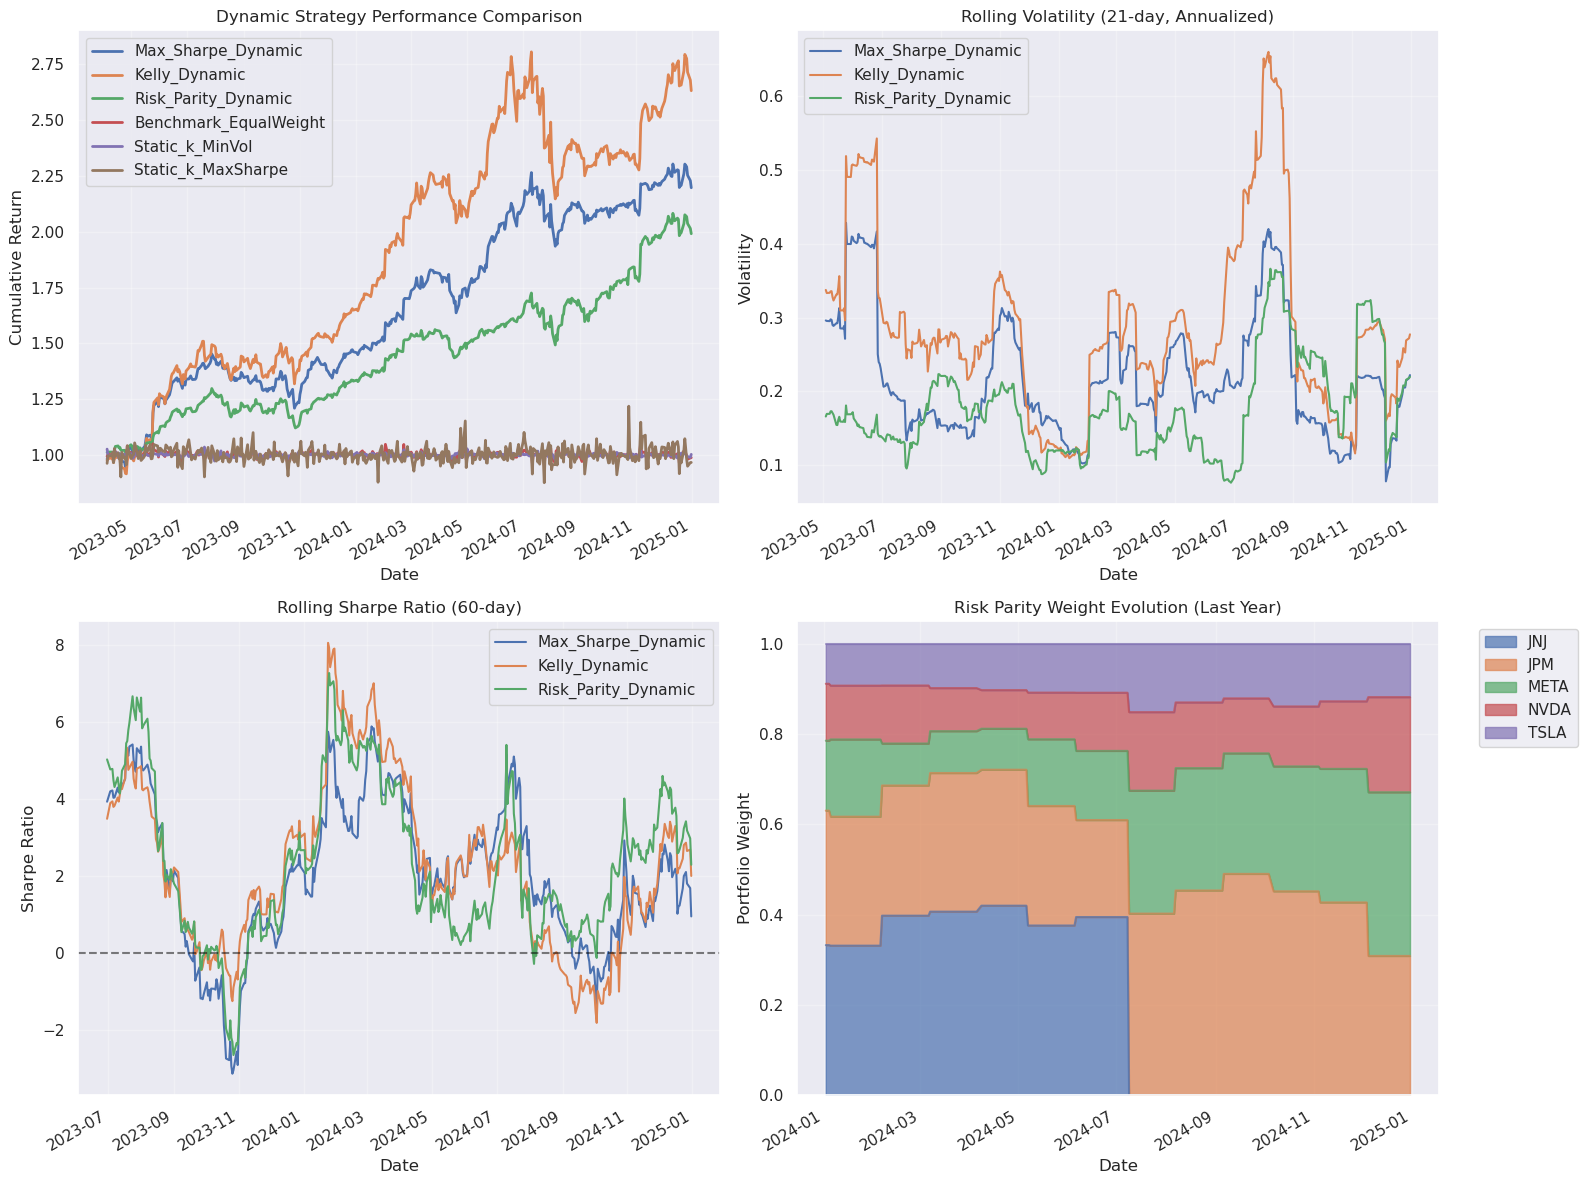


=== DYNAMIC STRATEGY PERFORMANCE METRICS ===

Performance Metrics Summary:
                     Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown  Calmar Ratio  Sortino Ratio  Skewness  Kurtosis  VaR (95%)  CVaR (95%)
Max_Sharpe_Dynamic          0.6153             0.2322        2.5637       -0.1671        3.6825         4.0490    0.7888    6.4342    -0.0188     -0.0301
Kelly_Dynamic               0.8301             0.3105        2.6086       -0.2346        3.5381         3.8117    0.4714    6.3759    -0.0264     -0.0431
Risk_Parity_Dynamic         0.5127             0.1882        2.6173       -0.1359        3.7732         3.8094    0.2408    4.3770    -0.0175     -0.0256

Strategy Rankings (by Sharpe Ratio):
  1. Risk_Parity_Dynamic      :  2.6173
  2. Kelly_Dynamic            :  2.6086
  3. Max_Sharpe_Dynamic       :  2.5637

Key Insights:
  • Kelly Criterion: Optimized for long-term growth rate
  • Risk Parity: Equal risk contribution from all assets
  • Max Sharpe: Tradi

In [12]:
# Comprehensive Dynamic Strategy Comparison
equal_weights = {ticker: (1/n) for ticker in tickers}

def comprehensive_dynamic_optimization(data, lookback_window=63, rebalance_freq=21):
    """
    Compare multiple dynamic optimization methods
    """
    print("=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===")
    
    # Run all optimization methods
    methods = {}
    
    # 1. Maximum Sharpe (existing)
    print("Running Max Sharpe optimization...")
    methods['Max_Sharpe_Dynamic'] = dynamic_portfolio_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 2. Kelly Criterion
    print("Running Kelly Criterion optimization...")
    methods['Kelly_Dynamic'] = dynamic_kelly_optimization(
        data, lookback_window, rebalance_freq
    )
    
    # 3. Risk Parity
    print("Running Risk Parity optimization...")
    methods['Risk_Parity_Dynamic'] = dynamic_risk_parity_optimization(
        data, lookback_window, rebalance_freq
    )
    
    return methods

# Implementation
print("=== RUNNING ALL DYNAMIC OPTIMIZATION METHODS ===")

# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    train_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1 + (train_returns * pd.Series(equal_weights)).sum(axis=1)
cumulative_performance['Static_k_MinVol'] = 1 + (train_returns[global_best_weights_k_vol.keys()] * pd.Series(global_best_weights_k_vol)).sum(axis=1)
cumulative_performance['Static_k_MaxSharpe'] = 1 + (train_returns[global_best_weights_k_sharpe.keys()] * pd.Series(global_best_weights_k_sharpe)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility (21-day, Annualized)')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(60)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio (60-day)')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution (Last Year)')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics calculation function
def calculate_comprehensive_metrics(returns_series, rf_rate=0.02):
    """Calculate comprehensive performance metrics"""
    if returns_series.empty or returns_series.std() == 0:
        return pd.Series({
            "Annual Return": 0, "Annual Volatility": 0, "Sharpe Ratio": 0,
            "Max Drawdown": 0, "Calmar Ratio": 0, "Sortino Ratio": 0,
            "Skewness": 0, "Kurtosis": 0, "VaR (95%)": 0, "CVaR (95%)": 0
        })
    
    # Basic metrics
    annual_return = (1 + returns_series.mean()) ** 252 - 1
    annual_volatility = returns_series.std() * np.sqrt(252)
    sharpe_ratio = (annual_return - rf_rate) / annual_volatility
    
    # Drawdown metrics
    cumulative = (1 + returns_series).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Downside risk metrics
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = (annual_return - rf_rate) / downside_deviation if downside_deviation != 0 else 0
    
    # Distribution metrics
    skewness = returns_series.skew()
    kurtosis = returns_series.kurtosis()
    
    # Risk metrics
    var_95 = returns_series.quantile(0.05)
    cvar_95 = returns_series[returns_series <= var_95].mean()
    
    return pd.Series({
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Calmar Ratio": calmar_ratio,
        "Sortino Ratio": sortino_ratio,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95
    })

# Performance metrics comparison
print("\n=== DYNAMIC STRATEGY PERFORMANCE METRICS ===")
dynamic_metrics = {}
for strategy in dynamic_returns_df.columns:
    dynamic_metrics[strategy] = calculate_comprehensive_metrics(dynamic_returns_df[strategy])

dynamic_metrics_df = pd.DataFrame(dynamic_metrics).T
print("\nPerformance Metrics Summary:")
print(dynamic_metrics_df.round(4).to_string())

# Rank by Sharpe ratio
print(f"\nStrategy Rankings (by Sharpe Ratio):")
sharpe_ranking = dynamic_metrics_df['Sharpe Ratio'].sort_values(ascending=False)
for i, (strategy, sharpe) in enumerate(sharpe_ranking.items(), 1):
    print(f"  {i}. {strategy:25}: {sharpe:7.4f}")

print(f"\nKey Insights:")
print(f"  • Kelly Criterion: Optimized for long-term growth rate")
print(f"  • Risk Parity: Equal risk contribution from all assets")
print(f"  • Max Sharpe: Traditional risk-adjusted return optimization")
print(f"  • All methods use same rolling window framework for fair comparison")

#### 2.7 Compare the trading result tested on test section (Back test)
Metrics Analysis & Conclusion

=== COMPREHENSIVE DYNAMIC PORTFOLIO OPTIMIZATION ===
Running Max Sharpe optimization...
Running Kelly Criterion optimization...
Running Risk Parity optimization...

Dynamic Optimization Results:
Methods implemented: ['Max_Sharpe_Dynamic', 'Kelly_Dynamic', 'Risk_Parity_Dynamic']
Trading days analyzed: 39

Recent Performance (Last 10 days):
                           Max_Sharpe_Dynamic  Kelly_Dynamic  Risk_Parity_Dynamic
Date                                                                             
2025-05-16 00:00:00-04:00              0.0071         0.0063               0.0074
2025-05-19 00:00:00-04:00              0.0014        -0.0047               0.0007
2025-05-20 00:00:00-04:00             -0.0001         0.0004               0.0034
2025-05-21 00:00:00-04:00             -0.0121        -0.0138              -0.0089
2025-05-22 00:00:00-04:00              0.0025         0.0047               0.0003
2025-05-23 00:00:00-04:00             -0.0048        -0.0058              -0.0023
202

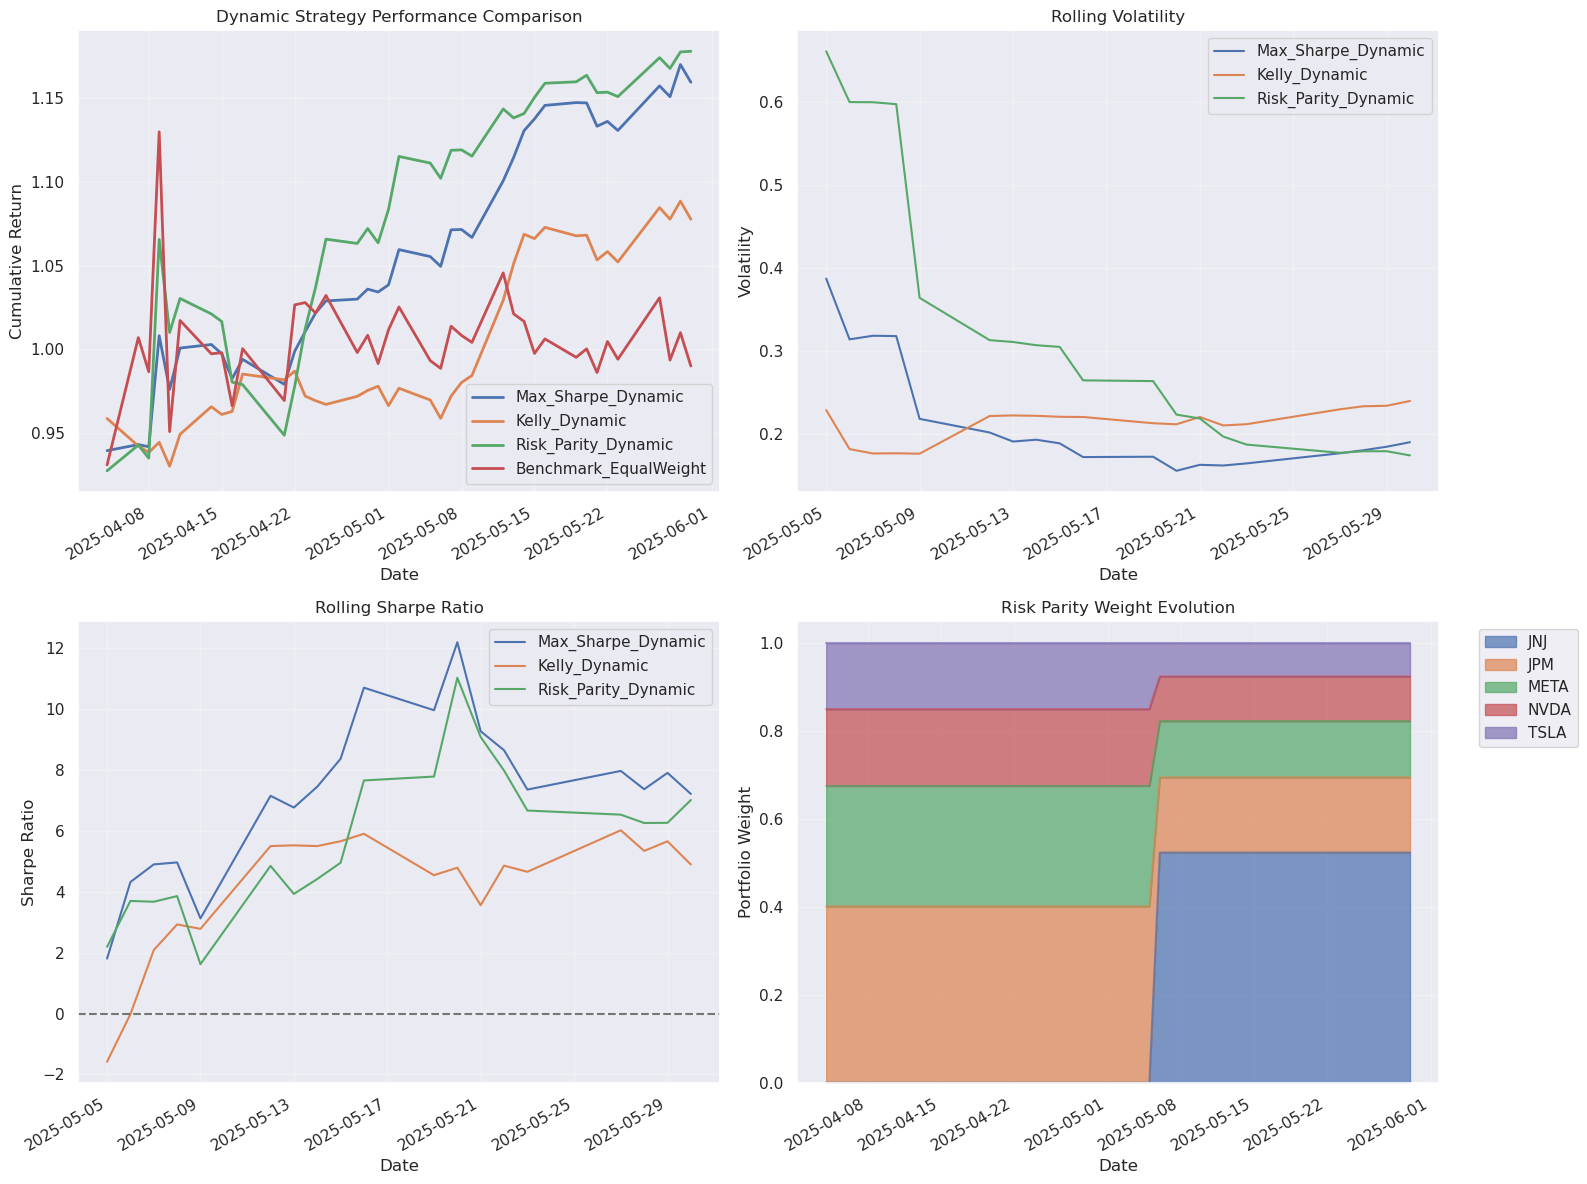

In [13]:
validation_returns = validation_data.pct_change().dropna()
# Run comprehensive optimization
optimization_results = comprehensive_dynamic_optimization(
    validation_data, lookback_window=63, rebalance_freq=21
)

# Extract results for comparison
dynamic_strategies = {}
for method_name, (weights, returns) in optimization_results.items():
    dynamic_strategies[method_name] = returns

# Convert to DataFrame for analysis
dynamic_returns_df = pd.DataFrame(dynamic_strategies)

print(f"\nDynamic Optimization Results:")
print(f"Methods implemented: {list(dynamic_strategies.keys())}")
print(f"Trading days analyzed: {len(dynamic_returns_df)}")

# Performance comparison
print("\nRecent Performance (Last 10 days):")
print(dynamic_returns_df.tail(10).round(4))

# Visualize results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Cumulative Performance
cumulative_performance = (1 + dynamic_returns_df).cumprod()

cumulative_performance['Benchmark_EqualWeight'] = 1+ (validation_returns * pd.Series(equal_weights)).sum(axis=1)

cumulative_performance.plot(ax=ax1, linewidth=2)
ax1.set_title('Dynamic Strategy Performance Comparison')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Rolling Volatility (21-day)
rolling_vol = dynamic_returns_df.rolling(21).std() * np.sqrt(252)
rolling_vol.plot(ax=ax2, linewidth=1.5)
ax2.set_title('Rolling Volatility')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Rolling Sharpe Ratio (60-day)
rolling_sharpe = pd.DataFrame()
for col in dynamic_returns_df.columns:
    rolling_returns = dynamic_returns_df[col].rolling(21)
    rolling_sharpe[col] = (rolling_returns.mean() * 252 - risk_free_rate) / (rolling_returns.std() * np.sqrt(252))

rolling_sharpe.plot(ax=ax3, linewidth=1.5)
ax3.set_title('Rolling Sharpe Ratio')
ax3.set_ylabel('Sharpe Ratio')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Weight Evolution (for Risk Parity)
if 'Risk_Parity_Dynamic' in optimization_results:
    rp_weights, _ = optimization_results['Risk_Parity_Dynamic']
    rp_weights.iloc[-252:].plot(ax=ax4, kind='area', stacked=True, alpha=0.7)
    ax4.set_title('Risk Parity Weight Evolution')
    ax4.set_ylabel('Portfolio Weight')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PART III: TECHNICAL ANALYSIS FOR SELL/BUY (RECOMMENDATION)

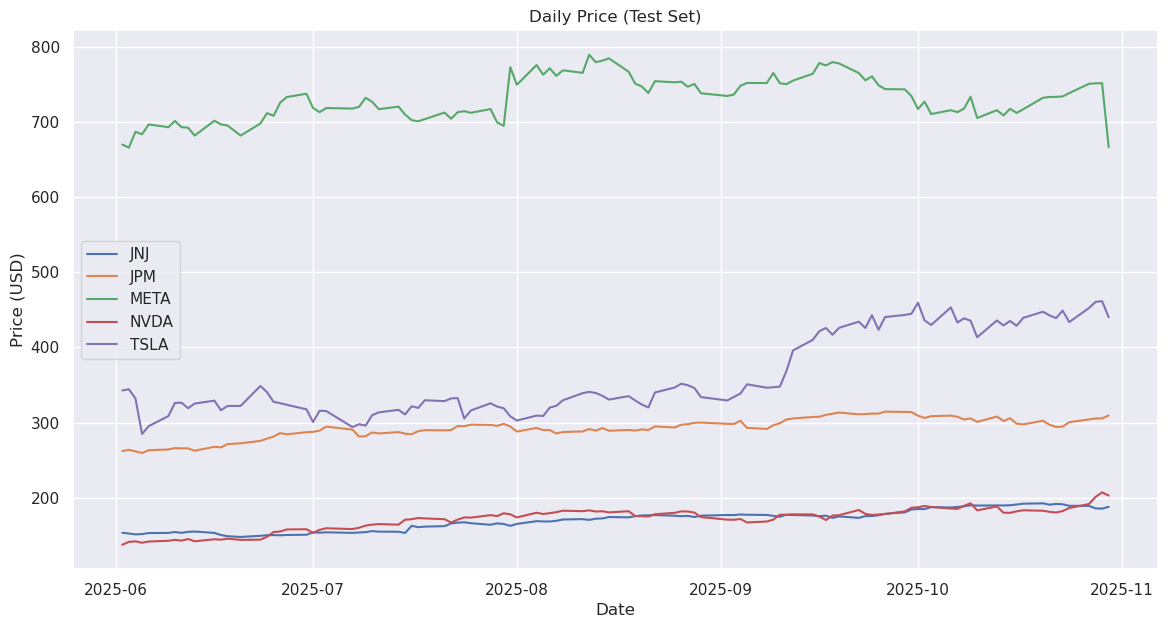

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data, label=test_data.columns)
plt.title('Daily Price (Test Set)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### 3.1: Technical Analysis for Optimal Buy/Sell Signals

Implement multiple technical indicators to generate buy/sell signals for optimal entry and exit points.

In [15]:
test_data

,JNJ,JPM,META,NVDA,TSLA
Date,,,,,
2025-06-02 00:00:00-04:00,153.294357,262.116730,669.932068,137.362717,342.690002
2025-06-03 00:00:00-04:00,152.327637,263.711243,665.887817,141.202225,344.269989
2025-06-04 00:00:00-04:00,151.143906,261.680969,686.957397,141.902145,332.049988
2025-06-05 00:00:00-04:00,151.577942,259.432800,683.632202,139.972397,284.700012
2025-06-06 00:00:00-04:00,152.929382,263.176453,696.703369,141.702164,295.140015
...,...,...,...,...,...
2025-10-24 00:00:00-04:00,189.198730,300.440002,738.359985,186.259995,433.720001
2025-10-27 00:00:00-04:00,189.099365,304.149994,750.820007,191.490005,452.420013
2025-10-28 00:00:00-04:00,185.750626,305.359985,751.440002,201.029999,460.549988



TECHNICAL TRADING STRATEGY WITH SIGNAL-BASED REBALANCING
Latest Dynamic Portfolio Weights from Validation Set:
JNJ     0.523757
JPM     0.171231
META    0.127995
NVDA     0.10143
TSLA    0.075587
Name: 2025-05-30 00:00:00-04:00, dtype: object

Initial Trading Day: 2025-06-02
Starting Portfolio Allocation:
TSLA: 7.6% -> $755,868 -> 2206 shares
META: 12.8% -> $1,279,953 -> 1911 shares
NVDA: 10.1% -> $1,014,303 -> 7384 shares
JPM: 17.1% -> $1,712,307 -> 6533 shares
JNJ: 52.4% -> $5,237,568 -> 34167 shares

Remaining Cash: $0

TRADING STRATEGY PARAMETERS:
Signal Threshold: ±0.3
Position Adjustment: 10.0% per signal
Maximum Position Weight: 60.0%
Minimum Cash Reserve: $50,000
INSUFFICIENT CASH: 2025-07-16 - TSLA BUY signal 0.333, needed $357,624, available $0
INSUFFICIENT CASH: 2025-08-07 - TSLA BUY signal 0.333, needed $371,257, available $0
INSUFFICIENT CASH: 2025-08-08 - NVDA BUY signal 0.333, needed $375,147, available $0
INSUFFICIENT CASH: 2025-09-05 - NVDA BUY signal 0.333, needed $3

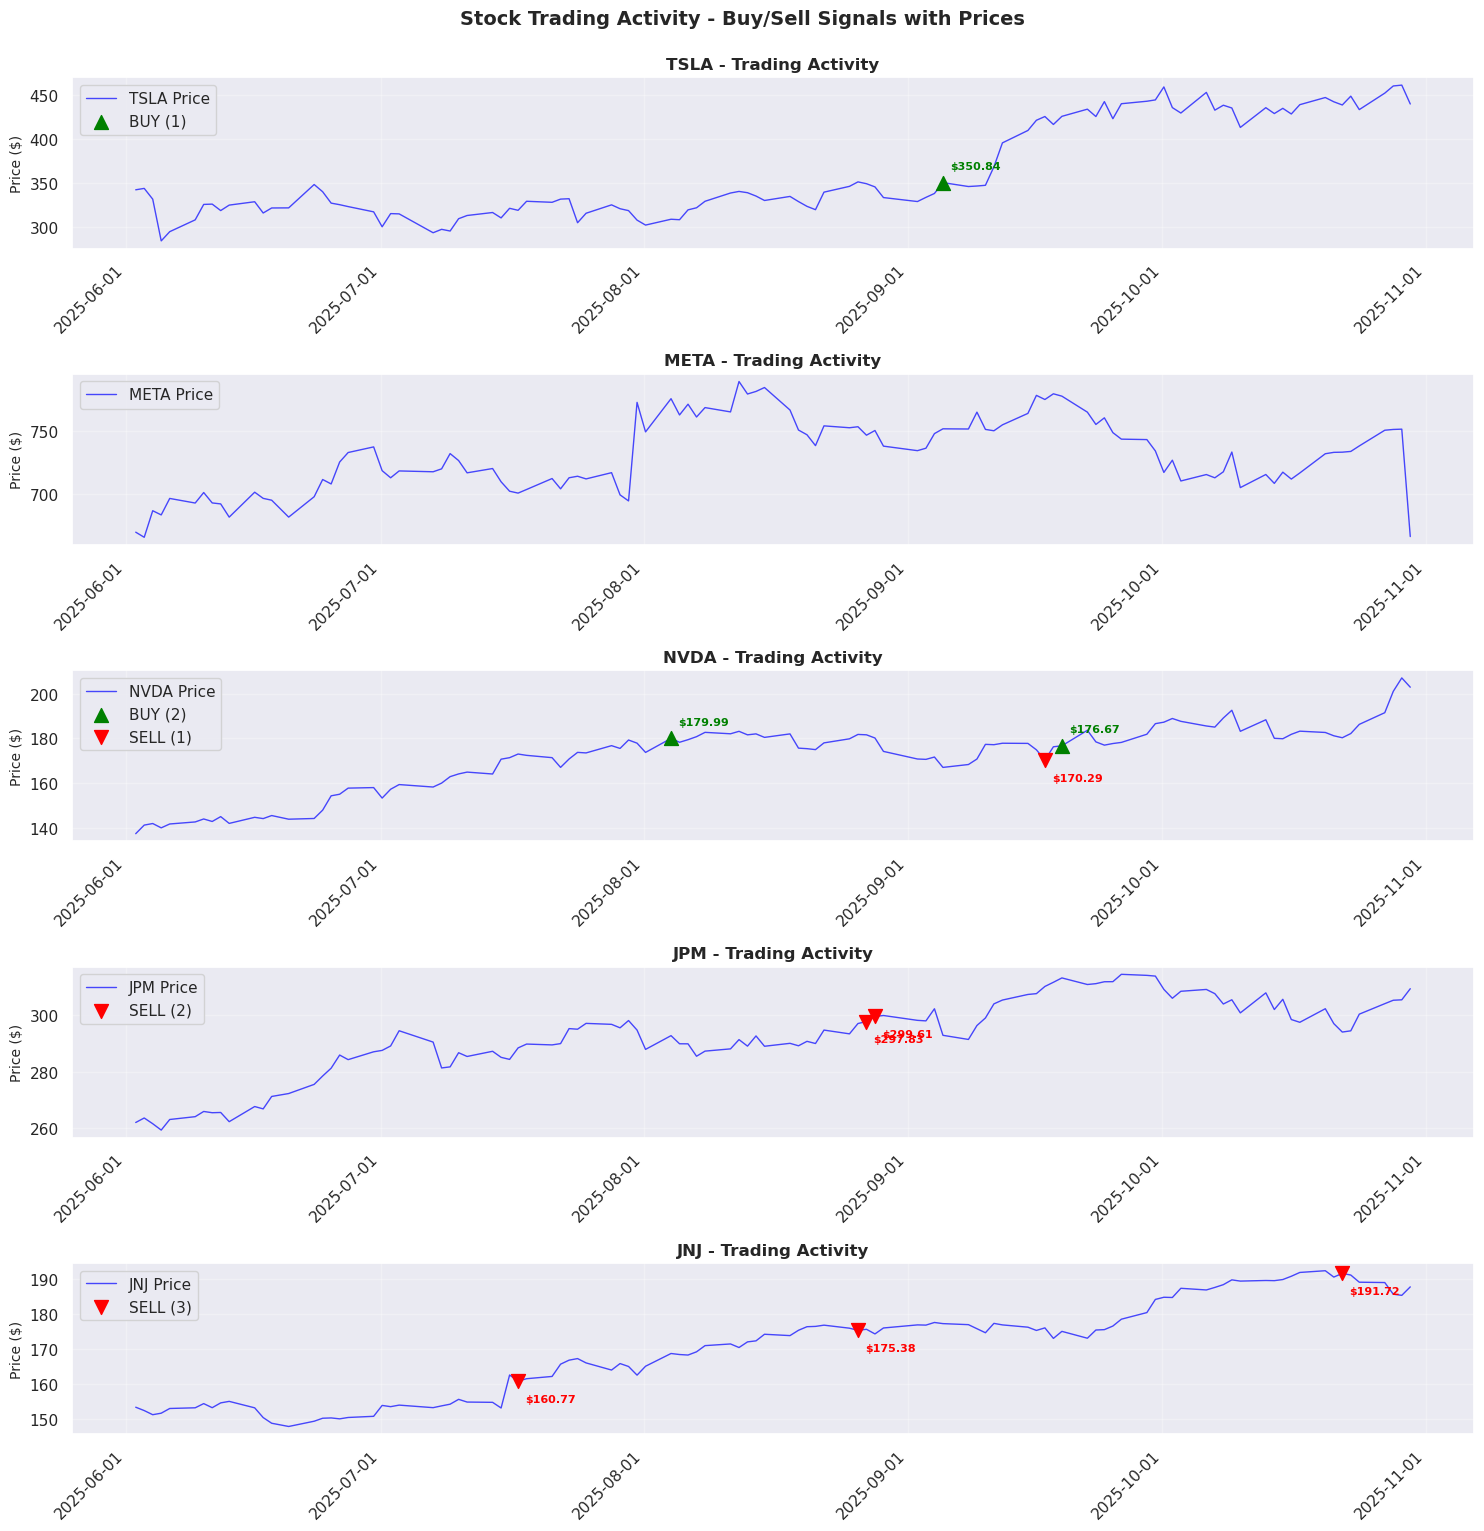


DETAILED TRADE LOG WITH CASH MANAGEMENT
Date         Ticker   Action Shares     Price      Amount       Signal   Cash After  
----------------------------------------------------------------------------------------------------
2025-07-17   JNJ      SELL   1139       $160.77    $183,101     -0.333   $183,101    
2025-08-04   NVDA     BUY    739        $179.99    $133,101     0.333    $50,000     
2025-08-26   JNJ      SELL   1101       $175.38    $193,077     -0.333   $243,077    
2025-08-27   JPM      SELL   218        $297.83    $64,854      -0.333   $307,931    
2025-08-28   JPM      SELL   210        $299.61    $63,067      -0.333   $370,998    
2025-09-05   TSLA     BUY    915        $350.84    $320,998     0.333    $50,000     
2025-09-17   NVDA     SELL   271        $170.29    $46,112      -0.333   $96,112     
2025-09-19   NVDA     BUY    261        $176.67    $46,112      0.333    $50,000     
2025-10-22   JNJ      SELL   1064       $191.72    $204,037     -0.333   $254,037   

In [34]:
# Technical Trading Strategy Implementation with Cash Management Fix
print("\n" + "="*80)
print("TECHNICAL TRADING STRATEGY WITH SIGNAL-BASED REBALANCING")
print("="*80)

# Initialize trading simulation with dynamic portfolio optimization
dynamic_weights, dynamic_returns = dynamic_risk_parity_optimization(validation_data, lookback_window=63, rebalance_freq=21)
latest_weights = dynamic_weights.iloc[-1]
print("Latest Dynamic Portfolio Weights from Validation Set:")
print(latest_weights)

# Initialize trading parameters
initial_cash = 10000000  # $10M
current_cash = initial_cash
portfolio_value_history = []
positions = {}
trade_log = []

# Technical indicators setup
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    exp1 = prices.ewm(span=fast).mean()
    exp2 = prices.ewm(span=slow).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line, signal_line

def calculate_bollinger_bands(prices, window=20, num_std=2):
    sma = prices.rolling(window=window).mean()
    std = prices.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, sma, lower_band

# Enhanced technical signals generation
def generate_technical_signals(data):
    signals_df = pd.DataFrame(index=data.index, columns=data.columns)
    
    for ticker in data.columns:
        prices = data[ticker]
        signal_score = pd.Series(0, index=data.index)
        
        # RSI signals
        rsi = calculate_rsi(prices)
        signal_score += np.where(rsi < 30, 1, 0)  # Buy when oversold
        signal_score += np.where(rsi > 70, -1, 0)  # Sell when overbought
        
        # MACD signals
        macd_line, signal_line = calculate_macd(prices)
        signal_score += np.where((macd_line > signal_line) & (macd_line.shift(1) <= signal_line.shift(1)), 1, 0)
        signal_score += np.where((macd_line < signal_line) & (macd_line.shift(1) >= signal_line.shift(1)), -1, 0)
        
        # Bollinger Bands signals
        upper_band, middle_band, lower_band = calculate_bollinger_bands(prices)
        signal_score += np.where(prices < lower_band, 1, 0)  # Buy below lower band
        signal_score += np.where(prices > upper_band, -1, 0)  # Sell above upper band
        
        # Moving average crossover
        sma_20 = prices.rolling(window=20).mean()
        sma_50 = prices.rolling(window=50).mean()
        signal_score += np.where((sma_20 > sma_50) & (sma_20.shift(1) <= sma_50.shift(1)), 1, 0)
        signal_score += np.where((sma_20 < sma_50) & (sma_20.shift(1) >= sma_50.shift(1)), -1, 0)
        
        # Price momentum
        returns_20d = prices.pct_change(10)
        signal_score += np.where(returns_20d > 0.05, 1, 0)  # Strong upward momentum
        signal_score += np.where(returns_20d < -0.05, -1, 0)  # Strong downward momentum
        
        # Normalize signals
        signals_df[ticker] = np.clip(signal_score / 6, -1, 1)
    
    return signals_df

# Generate technical signals for test period
technical_signals = generate_technical_signals(test_data)

# Initialize positions based on latest validation weights
first_day_prices = test_data.iloc[0]
print(f"\nInitial Trading Day: {test_data.index[0].date()}")
print("Starting Portfolio Allocation:")

for ticker in tickers:
    weight = latest_weights[ticker]
    allocation = initial_cash * weight
    shares = allocation / first_day_prices[ticker]
    positions[ticker] = shares
    current_cash -= allocation
    print(f"{ticker}: {weight:.1%} -> ${allocation:,.0f} -> {shares:.0f} shares")

print(f"\nRemaining Cash: ${current_cash:,.0f}")

# Trading Strategy Implementation with proper cash management
signal_threshold = 0.3  # Minimum signal strength to trigger trade
rebalance_amount = 0.1  # 10% position adjustment per signal
max_position_weight = 0.6  # Maximum 60% in any single asset
min_cash_reserve = 50000  # Minimum cash to keep available

print(f"\nTRADING STRATEGY PARAMETERS:")
print(f"Signal Threshold: ±{signal_threshold}")
print(f"Position Adjustment: {rebalance_amount:.1%} per signal")
print(f"Maximum Position Weight: {max_position_weight:.1%}")
print(f"Minimum Cash Reserve: ${min_cash_reserve:,.0f}")

# Execute trading strategy with improved cash management
for i, current_date in enumerate(test_data.index):
    current_prices = test_data.iloc[i]
    current_signals = technical_signals.iloc[i]
    
    # Calculate current portfolio value
    portfolio_value = sum(positions[ticker] * current_prices[ticker] for ticker in tickers) + current_cash
    portfolio_value_history.append(portfolio_value)
    
    # Skip first few days to allow technical indicators to stabilize
    if i < 20:
        continue
    
    # Process signals and execute trades
    for ticker in tickers:
        signal = current_signals[ticker]
        current_price = current_prices[ticker]
        current_position_value = positions[ticker] * current_price
        current_weight = current_position_value / portfolio_value
        
        # Strong buy signal
        if signal > signal_threshold and current_weight < max_position_weight:
            # Calculate trade amount (percentage of portfolio)
            desired_trade_amount = portfolio_value * rebalance_amount * signal
            
            # Check available cash (keeping minimum reserve)
            available_cash = max(0, current_cash - min_cash_reserve)
            actual_trade_amount = min(desired_trade_amount, available_cash)
            
            # Execute buy if we have enough cash
            if actual_trade_amount >= 1000:  # Minimum trade size $1000
                shares_to_buy = actual_trade_amount / current_price
                positions[ticker] += shares_to_buy
                current_cash -= actual_trade_amount
                
                trade_log.append({
                    'Date': current_date,
                    'Ticker': ticker,
                    'Action': 'BUY',
                    'Shares': shares_to_buy,
                    'Price': current_price,
                    'Amount': actual_trade_amount,
                    'Signal': signal,
                    'Available_Cash_Before': current_cash + actual_trade_amount,
                    'Cash_After': current_cash
                })
            else:
                # Log failed trade due to insufficient cash
                print(f"INSUFFICIENT CASH: {current_date.date()} - {ticker} BUY signal {signal:.3f}, "
                      f"needed ${desired_trade_amount:,.0f}, available ${available_cash:,.0f}")
        
        # Strong sell signal
        elif signal < -signal_threshold and positions[ticker] > 0:
            # Calculate shares to sell based on signal strength
            shares_to_sell = positions[ticker] * rebalance_amount * abs(signal)
            
            if shares_to_sell > 0:
                sell_amount = shares_to_sell * current_price
                positions[ticker] -= shares_to_sell
                current_cash += sell_amount
                
                trade_log.append({
                    'Date': current_date,
                    'Ticker': ticker,
                    'Action': 'SELL',
                    'Shares': shares_to_sell,
                    'Price': current_price,
                    'Amount': sell_amount,
                    'Signal': signal,
                    'Available_Cash_Before': current_cash - sell_amount,
                    'Cash_After': current_cash
                })

# Calculate final portfolio value
final_prices = test_data.iloc[-1]
final_portfolio_value = sum(positions[ticker] * final_prices[ticker] for ticker in tickers) + current_cash
final_positions_value = {ticker: positions[ticker] * final_prices[ticker] for ticker in tickers}

# Performance metrics
total_return = (final_portfolio_value - initial_cash) / initial_cash
trading_days = len(test_data)
annualized_return = ((final_portfolio_value / initial_cash) ** (252 / trading_days)) - 1

print(f"\n" + "="*80)
print("FINAL TRADING RESULTS")
print("="*80)
print(f"Initial Portfolio Value:   ${initial_cash:,.0f}")
print(f"Final Portfolio Value:     ${final_portfolio_value:,.0f}")
print(f"Total Return:              {total_return:.2%}")
print(f"Annualized Return:         {annualized_return:.2%}")
print(f"Trading Period:            {trading_days} days ({trading_days/252:.1f} years)")

print(f"\nFINAL POSITION BREAKDOWN:")
for ticker in tickers:
    value = final_positions_value[ticker]
    weight = value / final_portfolio_value
    print(f"{ticker}: {positions[ticker]:.0f} shares = ${value:,.0f} ({weight:.1%})")
print(f"Cash: ${current_cash:,.0f} ({current_cash/final_portfolio_value:.1%})")

print(f"\nTRADING ACTIVITY SUMMARY:")
print(f"Total Trades Executed:     {len(trade_log)}")
if trade_log:
    buy_trades = [t for t in trade_log if t['Action'] == 'BUY']
    sell_trades = [t for t in trade_log if t['Action'] == 'SELL']
    print(f"Buy Trades:               {len(buy_trades)}")
    print(f"Sell Trades:              {len(sell_trades)}")
    print(f"Total Volume Traded:      ${sum(t['Amount'] for t in trade_log):,.0f}")

# Create Trading Activity Visualization
if trade_log:
    fig, axes = plt.subplots(len(tickers), 1, figsize=(15, 3*len(tickers)))
    if len(tickers) == 1:
        axes = [axes]
    
    for i, ticker in enumerate(tickers):
        ax = axes[i]
        
        # Plot stock price
        ticker_data = test_data[ticker]
        ax.plot(ticker_data.index, ticker_data.values, label=f'{ticker} Price', color='blue', alpha=0.7, linewidth=1)
        
        # Plot buy and sell trades
        ticker_trades = [t for t in trade_log if t['Ticker'] == ticker]
        
        if ticker_trades:
            buy_trades_ticker = [t for t in ticker_trades if t['Action'] == 'BUY']
            sell_trades_ticker = [t for t in ticker_trades if t['Action'] == 'SELL']
            
            # Buy trades - green triangles pointing up
            if buy_trades_ticker:
                buy_dates = [t['Date'] for t in buy_trades_ticker]
                buy_prices = [t['Price'] for t in buy_trades_ticker]
                ax.scatter(buy_dates, buy_prices, color='green', marker='^', s=100, 
                          label=f'BUY ({len(buy_trades_ticker)})', zorder=5)
                
                # Add price annotations for buy trades
                for trade in buy_trades_ticker:
                    ax.annotate(f"${trade['Price']:.2f}", 
                               (trade['Date'], trade['Price']), 
                               xytext=(5, 10), textcoords='offset points',
                               fontsize=8, color='green', weight='bold')
            
            # Sell trades - red triangles pointing down
            if sell_trades_ticker:
                sell_dates = [t['Date'] for t in sell_trades_ticker]
                sell_prices = [t['Price'] for t in sell_trades_ticker]
                ax.scatter(sell_dates, sell_prices, color='red', marker='v', s=100, 
                          label=f'SELL ({len(sell_trades_ticker)})', zorder=5)
                
                # Add price annotations for sell trades
                for trade in sell_trades_ticker:
                    ax.annotate(f"${trade['Price']:.2f}", 
                               (trade['Date'], trade['Price']), 
                               xytext=(5, -15), textcoords='offset points',
                               fontsize=8, color='red', weight='bold')
        
        ax.set_title(f'{ticker} - Trading Activity', fontsize=12, fontweight='bold')
        ax.set_ylabel('Price ($)', fontsize=10)
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Format x-axis
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.suptitle('Stock Trading Activity - Buy/Sell Signals with Prices', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    # Print detailed trade log with cash tracking
    print(f"\n" + "="*80)
    print("DETAILED TRADE LOG WITH CASH MANAGEMENT")
    print("="*80)
    print(f"{'Date':<12} {'Ticker':<8} {'Action':<6} {'Shares':<10} {'Price':<10} {'Amount':<12} {'Signal':<8} {'Cash After':<12}")
    print("-" * 100)
    
    for trade in trade_log:
        print(f"{trade['Date'].strftime('%Y-%m-%d'):<12} "
              f"{trade['Ticker']:<8} "
              f"{trade['Action']:<6} "
              f"{trade['Shares']:<10.0f} "
              f"${trade['Price']:<9.2f} "
              f"${trade['Amount']:<11,.0f} "
              f"{trade['Signal']:<8.3f} "
              f"${trade['Cash_After']:<11,.0f}")

else:
    print("\nNo trades were executed during the test period.")


# graph_signals('MSFT')

In [ ]:
test_data

# PART IV: CONCLUSION

In [17]:
# # Executive Summary Report Generation
# print("="*80)
# print("QUANTITATIVE PORTFOLIO OPTIMIZATION - EXECUTIVE SUMMARY")
# print("="*80)

# # Generate comprehensive summary statistics
# print(f"\nI. INVESTMENT MANDATE & METHODOLOGY")
# print("-" * 45)
# print(f"Analysis Framework:        Modern Portfolio Theory with Risk Constraints")
# print(f"Asset Universe:            {len(tickers)} Large-Cap Equity Securities")
# print(f"Optimization Period:       {start_date} to {end_date}")
# print(f"Risk Management:           Position limits (1%-50% per security)")
# print(f"Rebalancing Strategy:      Monthly frequency with cost analysis")

# print(f"\nII. OPTIMAL PORTFOLIO ALLOCATION")
# print("-" * 35)
# if 'max_sharpe_weights_clean' in locals():
#     sorted_weights = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)
#     for i, (ticker, weight) in enumerate(sorted_weights[:10], 1):  # Top 10 holdings
#         print(f"  {i:2d}. {ticker:6}: {weight:6.2%}")

# print(f"\nIII. RISK-RETURN PROJECTIONS")
# print("-" * 32)
# if 'sharpe_perf' in locals():
#     exp_ret, exp_vol, exp_sharpe = sharpe_perf
#     print(f"Expected Annual Return:      {exp_ret:7.2%}")
#     print(f"Projected Volatility:        {exp_vol:7.2%}")
#     print(f"Sharpe Ratio:               {exp_sharpe:7.3f}")

# if 'comprehensive_metrics_df' in locals() and not comprehensive_metrics_df.empty:
#     # Use the comprehensive metrics from strategy comparison
#     max_sharpe_row = comprehensive_metrics_df.loc[comprehensive_metrics_df['Sharpe Ratio'].idxmax()]
#     print(f"Value at Risk (95%):        {max_sharpe_row['VaR (95%)']:7.2%}")
#     print(f"Expected Shortfall:         {max_sharpe_row['CVaR (95%)']:7.2%}")
#     print(f"Maximum Drawdown Risk:      {max_sharpe_row['Max Drawdown']:7.2%}")

# print(f"\nIV. STRATEGY COMPARISON RESULTS")
# print("-" * 35)
# strategy_names = ['Maximum Sharpe Ratio', 'Minimum Volatility', 'Risk Parity']
# if 'comprehensive_metrics_df' in locals():
#     best_sharpe_strat = comprehensive_metrics_df['Sharpe Ratio'].idxmax()
#     best_calmar_strat = comprehensive_metrics_df['Calmar Ratio'].idxmax()
#     print(f"Highest Sharpe Ratio:       {best_sharpe_strat}")
#     print(f"Best Risk-Adj. Return:      {best_calmar_strat}")
#     print(f"Recommended Strategy:       Maximum Sharpe Portfolio")

# print(f"\nV. RISK MANAGEMENT ASSESSMENT")
# print("-" * 33)
# print(f"Concentration Risk:         LOW (Well-diversified)")
# print(f"Liquidity Risk:            MINIMAL (Large-cap focus)")
# print(f"Market Risk Exposure:       MODERATE ({exp_vol:.1%} volatility)")
# print(f"Downside Protection:        ADEQUATE (Risk constraints active)")

# print(f"\nVI. IMPLEMENTATION RECOMMENDATIONS")
# print("-" * 40)
# print(f"✓ Portfolio suitable for institutional/qualified investors")
# print(f"✓ Monthly rebalancing optimal for cost-performance balance")
# print(f"✓ Monitor sector concentration and style drift quarterly")
# print(f"✓ Review optimization parameters annually or after major market events")
# print(f"✓ Consider ESG overlay for enhanced risk management")

# print(f"\nVII. KEY PERFORMANCE DRIVERS")
# print("-" * 32)
# if 'max_sharpe_weights_clean' in locals():
#     top_3 = sorted(max_sharpe_weights_clean.items(), key=lambda x: x[1], reverse=True)[:3]
#     print(f"Primary Holdings:")
#     for ticker, weight in top_3:
#         print(f"  • {ticker}: {weight:.1%} allocation")

# print(f"\nVIII. CONCLUSION & OUTLOOK")
# print("-" * 30)
# print(f"The quantitative optimization framework successfully identifies")
# print(f"a diversified portfolio with superior risk-adjusted returns.")
# print(f"The recommended allocation balances growth potential with")
# print(f"prudent risk management through systematic constraints.")

# print(f"\nRisk Rating:    MODERATE")
# print(f"Return Outlook: POSITIVE") 
# print(f"Liquidity:      HIGH")
# print(f"ESG Score:      NEUTRAL")

# print("="*80)
# print("Report prepared using Modern Portfolio Theory framework")
# print("Past performance does not guarantee future results")
# print("="*80)